# Into to the tutorial

This tutorial is designed to assist you in applying deep learning techniques to your individual tasks and datasets.
In order to get the most out of this tutoral, acquiring familiarity with fundamental concepts in deep learning would be advantageous.

Here are good sources to start from:

- Courses: <a href="http://cs231n.stanford.edu/">CS231N</a> from Stanford or the DL4CV course from Weizmann.
- Blog posts: <a href="https://medium.com/@himadrisankarchatterjee/a-basic-introduction-to-convolutional-neural-network-8e39019b27c4">A basic introduction to convolutional neural network</a>

For now you only need to understand the basics:
- What are CNNs? 
- What is backpropogation? 
- What is a loss function? (And how to optimize them)

However, we strongly encourage you to delve into advanced deep learning concepts as you progress.

<i><b>This tutorial will use pytorch as its basic deep learning library. This tutorial will guide through using the library and will direct you to refer to the documentation when necessary.</b></i>

# Cell classification

In this tutorial we will focus on the task of cell classification. Cell classification of the vast number of cells within tissues, encompassing various cell types, presents a significant bottleneck for many biologists. <br> The process often involves labor-intensive manual labeling and visual examination of multiple protein stains per cell.
<br>
Multiplex imaging, an emerging technique for multiple protein staining in tissues, enables spatial analysis of multiple proteins with high resolution.

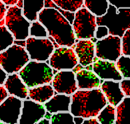
 
Above you can see a cropped multiplex image (MIBI) illustrating two proteins (each color representing a distinct protein). The proteins can overlap and do not precisely align with the cell segmentation, posing a challenge for cell classification.


Your task is to design a computer vision-oriented method that will work directly on the images of the cells. The method should be based on a neural network model such as CNNs.
<br>
The input of this method will be multiplex images containing thousands of cells along with corresponding ground truth labels indicating the cell types.
<br>
The output will be a model that given a new set of images will predict the cell types of each cell in the image.

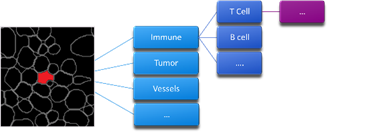

## Part 1: Creating The Dataset

Let's get to know the data we are working on, the data can be found in:

In [1]:
path = "/home/projects/aihubadm/aihub_shared/ex-cell-classification/Multiplexed_Images"

The data above contains:
- The multidimensional images ("data/images") where each image has a shape of (H, W, C) where C represents the number of channels in the input, and H, W represent the image size. Note that each image represents a segment from a tissue containing thousands of cells, with each channel representing a different protein expressed in the tissue.
- The cell's segmantations ("cells") where each image has a shape of (H, W) and each pixel contains the cell id of a cell is present at that location and zero where there isn't any cell.
- The cell's cell types ("cells2labels") where each file corresponds to one image and contains a list of cell's types where the index of the list is the cell id and value is the cell type. Note that the cell types are represented here by their numerical id and not by their name.

<b> Important: The id of the image is in it's name. </b>

* In addition you are given a table with the locations of the cells in "cells_locations.csv" in this folder.

Let's load one image to get to know the data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = np.load(rf"{path}/data/images/1.npz")["data"]
seg = np.load(rf"{path}/cells/1.npz")["data"]
cells2labels = np.load(rf"{path}/cells2labels/1.npz")["data"]

In [18]:
seg.shape

(2048, 2048)

<div style="font-size: 20px;color:green;background:#D3D3D3"> &#187; Checking for understanding, Answer the following: </div> 

- What is the shape of the image?
- How many cells are in the image?
- How many channels (proteins) are in this dataset?
- How many cell types are in this dataset?

<div style="font-size: 20px;color:green;;background:#D3D3D3""> &#187; Answer Here: </div>

...

In [19]:
print("Image shape:", image.shape)

num_cells = len(np.unique(seg)) - 1  # Subtract 1 for background
print("Number of cells in the image:", num_cells)

num_channels = image.shape[2]
print("Number of channels (proteins):", num_channels)

num_cell_types = len(np.unique(cells2labels))
print("Number of cell types in the dataset:", num_cell_types)

Image shape: (2048, 2048, 25)
Number of cells in the image: 4332
Number of channels (proteins): 25
Number of cell types in the dataset: 10


Now we will load the cells_locations files. <br>
The meaning of each column in the cells' locations file:
- image_id refers to the id of the image
- cell_id refers to the id of the cell (note that the cell id are ranged from 1 to n, and cells2labels is already padded with zero in the first index)
- centroid-0 refers to the center of the cell along the height axis
- centroid-1 refers to the center of the cell on along width axis

In [4]:
data = pd.read_csv("cells_locations.csv", index_col=0)

In [5]:
data.head()

,image_id,cell_id,centroid-0,centroid-1
0,7,1,1,1156
1,7,2,2,1392
2,7,3,2,1521
3,7,4,3,37
4,7,5,2,340


We loaded the image with id 1. Let's pick a cell_id from this image:

In [6]:
data[data.image_id == 1].sample(random_state=33)

,image_id,cell_id,centroid-0,centroid-1
42861,1,2858,1311,954


Now let's view a crop of size 60px around some random cell:

- On the left we'll view channel 18 which correponds to the protein SOX10

- On the right we'll view the segmantaion of the cells in the crop

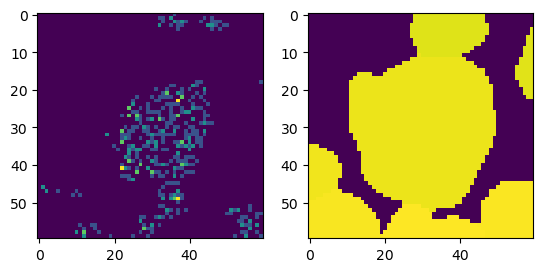

In [21]:
size_px=60
x_location, y_location = 1311, 954
crop = image[x_location-size_px//2:x_location+size_px//2,
    y_location-size_px//2:y_location+size_px//2, :]
seg_crop = seg[x_location-size_px//2:x_location+size_px//2,
    y_location-size_px//2:y_location+size_px//2]
_, axs = plt.subplots(1,2)
axs[0].imshow(crop[:,:,18])
axs[1].imshow(seg_crop)

Now that we are familiar with the data, let's create a Dataset object which will generate for us the data for the network. <br>
We want the input of the model to be a crop around each cell. We need to prepare the data in such way that each item will be a crop of all the proteins centered around each cell.
The dataset should implement a "\_\_getitem\_\_" function, for each index i of the dataset the \_\_getitem\_\_ will return the ith training sample, it's segmentation image and its ground truth.

* You can use the following tutorials for creating a custom Dataset using pytorch:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

    The terms you need to learn are <i>Dataset</i> and <i>DataLoader</i>.
    The Dataset will generate each item in your data and the DataLoader will warp the Dataset and provide an interface to iterate over the dataset batch by batch.

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
Fill the code in <b>dataset.py</b> and then import it to this notebook:

In [23]:
%load_ext autoreload
%autoreload 2
from dataset import CellsDataset

Now, you can test your code using the following code:

First we will filter cells on the borders:

In [24]:
img_size = 2048
crop_size = 60
data = data[(data["centroid-0"] > crop_size) & (data["centroid-0"] < img_size-crop_size)]
data = data[(data["centroid-1"] > crop_size) & (data["centroid-1"] < img_size-crop_size)]

Now we will split the dataset to training and testing sets, in order to test our model on unseen data. <br>
Note that we are spliting according to the image_ids in order to avoid data leakage.

* We split the cells in the data by their origin image in order to avoid inherent biases associated with individual images. This might lead to a positive misleading result since the model could learn those biases. More about data leakage can be read <a href="https://machinelearningmastery.com/data-leakage-machine-learning/">here</a>.
* In general we'll need to split according to the patient id as well as the image id, but for this tutorial we'll just split by the image id
* Think about your own dataset, are there any biases you should consider when splitting your data for training and testing?

In [25]:
images = data.image_id.unique()
images_train = images[:12]
images_test = images[12:]
data_train = data[data["image_id"].isin(images_train)]
data_test = data[data["image_id"].isin(images_test)]

Now we will create a dataset with the class you completed above. And then we'll create a data loader using the dataset. <br>
As mentioned above, the DataLoader warps our Dataset class and allows us to iterate over the data batch by batch. You can control the batch size in its parameters.
Here we are setting batch_size to 2 and we shuffle the data. <br>
Shuffling the training data ensures that our model sees random samples in each batch and doesn't view the batches in a specific order, which might introduce bias.

In [26]:
from torch.utils.data import DataLoader

In [27]:
train_dataset = CellsDataset(data_train)

train_loader = DataLoader(train_dataset, 
                          batch_size=2,
                          num_workers=1,
                          shuffle=True)

We'll now assert that the code worked correctly:

In [28]:
img, seg, gt = train_dataset[0]

In [29]:
assert gt == 1
assert img.shape[0] == crop_size
assert img.shape[1] == crop_size
assert img.shape[2] == 25

In [30]:
img, seg, gt = train_dataset[103]
assert gt == 15

In [31]:
#Asserting the returned image is the correct crop (checked on the cell in the example above)
img, seg, gt = train_dataset[(data.index==42861).argmax()]
assert (img != crop).sum() == 0
assert gt == 13
assert (seg != (seg_crop==2858)).sum() == 0

## Part 2: Building the model

### Background:

Resnet are CNN models, read more about them in the following <a href="https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8">link</a>

As a starter, let's create a Resnet model using pytorch. 
We will create a resent18 which is a resnet with 18 layers. As an input we will give it the number of classes we have. For now we will choose 2 classes as an example.

In [32]:
import torch 
from torch import nn
from torchvision import models as models

model = models.resnet18(num_classes=2)
x = torch.randn((1,3,100,100))
pred = model(x)
pred

tensor([[-1.0346,  0.3461]], grad_fn=<AddmmBackward0>)

* Note that the resnet here wasn't trained and the input was random therefor the output doesn't mean anything.
* Note that the input for the model has 4 channels:  (B, C, H, W) where <b>B</b> - batch size, <b>C</b> - number of the channels in the input, <b>H,W</b> - size of the crop around the cell. While the output of the model has 2 channels: (B, num of classes) where <b>B</b> - batch size.
* The model's output consists of the probabilities assigned to each sample for belonging to the two classes.

The optimization process for CNNs typically involves working with batches rather than optimizing on the entire dataset all at once. The batch size refers to the number of samples used to optimize the model in each iteration.

### Cell classification model

First we will build a model that given a multidimensional crop (around the center of the cell) will output a probability vector for each cell type.

For example if <b>x</b> is the input for the network then: <b>x has a shape of -> (B, C, H, W)</b>

<b>B</b> - batch size, <b>C</b> - number of the channels in the input, <b>H,W</b> - size of the crop around the cell.

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
<b> Fill the code in "model.py" </b>

Notes: 
- The model should be based on a resnet model. 
- Notice that resnet usually receive an RGB image as an input. You need to change it such that the input will match the number of channels in our data.
- Notice that you'll need to add a Softmax layer when the model is not training.

Now we'll import the model:

In [33]:
%load_ext autoreload
%autoreload 2
from model import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now check the code you wrote above using the following code:

In [34]:
model = Model(5, 2)
x = torch.randn((1,5,60,60))

In [35]:
model.eval()
y = model(x)

In [36]:
y.shape

torch.Size([1, 2])

In [37]:
assert y.shape[0] == x.shape[0]
assert y.shape[1] == 2
assert y.min() >= 0
assert y.max() <= 1

In the next sections, we will train and evaluate the model!